# INIT

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Librerias

In [2]:
!pip install featuretools # install the missing module

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.9/587.9 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.2/215.2 kB 13.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# MODULES PATH
import sys
sys.path.append('/content/drive/MyDrive/TFM_Retail_Repo/03_Clustering')

from modules import preprocessing_module as pm
from modules import kmeans_module as km_m
from modules.get_data import get_data
from modules import feature_creation_module as fcm

## Importacion datos

### CSVs

In [5]:
df_cal = get_data('exp_calendar.csv')
df_items = get_data('exp_items.csv')
df_shops = get_data('exp_shops.csv')
# df_ws = get_data('exp_weekly_sales.csv')
df_ws = get_data('daily_sales_with_events.csv') # Vamos a probar con diarias -> filtramos por años para que no pete la creacion de caracteristicas

/content/drive/MyDrive/TFM_Retail_Repo/03_Clustering/modules/get_data.py:23: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path)


In [6]:
display(df_cal.head())
display(df_items.head())
display(df_shops.head())
display(df_ws.head())

,fecha,event
0,2011-02-06,SuperBowl
1,2011-08-01,Ramadan starts
2,2011-11-24,Thanksgiving
3,2012-01-01,NewYear
4,2012-02-05,SuperBowl


,item,category,department
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1


,store_code,region,store
0,NYC_1,New York,Greenwich_Village
1,NYC_2,New York,Harlem
2,NYC_3,New York,Tribeca
3,NYC_4,New York,Brooklyn
4,BOS_1,Boston,South_End


,item,store_code,date,units,year,week,sell_price,raw_earn,month,day_name,weekday_number,event
0,ACCESORIES_1_008,NYC_1,2011-01-29,12,2011,4,0.6118,7.3416,1,Saturday,5,NaN
1,ACCESORIES_1_009,NYC_1,2011-01-29,2,2011,4,2.0748,4.1496,1,Saturday,5,NaN
2,ACCESORIES_1_015,NYC_1,2011-01-29,4,2011,4,0.9310,3.7240,1,Saturday,5,NaN
3,ACCESORIES_1_016,NYC_1,2011-01-29,5,2011,4,0.9310,4.6550,1,Saturday,5,NaN
4,ACCESORIES_1_022,NYC_1,2011-01-29,2,2011,4,9.1238,18.2476,1,Saturday,5,NaN


In [7]:
# Seleccionar solo años 2014 a 2016 de df_ws
df_ws = df_ws[(df_ws['year'] >= 2014) & (df_ws['year'] <= 2016)]

# Cambiamos NaN de event por None
df_ws['event'] = df_ws['event'].fillna('None')

display(df_ws.shape)

(9693001, 12)

# **CREACION CARACTERISTICAS**
___
___  
  
Creamos las caracteristicas generales y luego filtraremos para cada supuesto.

In [8]:
# V2
fc_config = {
    'target_df': 'items',  # Nombre del DataFrame objetivo
    'agg_primitives': [
        'min',               # Mínimo
        'max',               # Máximo
        'mean',              # Promedio
        'std',               # Desviación estándar
        'sum',               # Suma
        'count'              # Totales
    ],
    'trans_primitives': [
        # 'divide_numeric',    # División entre características numéricas -> GENERA MUCHAS!!!
        'percentile'       # Porcentaje de ventas respecto a la tienda de mayor rendimiento
    ],
    'max_depth': 2         # Profundidad máxima de la generación de características
}


feature_matrix, feature_defs = fcm.create_features(df_items, df_shops, df_ws, fc_config)

/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. 

In [9]:
print(f'FeatMatrix shape : {feature_matrix.shape}')

print(f'Feat Defs length: {len(feature_defs)}')

FeatMatrix shape : (3049, 109)
Feat Defs length: 109


### Feat Descriptions

In [10]:
# Revision definiciones caracteristicas creadas
features_descriptions = fcm.get_features_descriptions(feature_defs)

display(type(features_descriptions))

display(features_descriptions)

list

['<Feature: category>: The "category".',
 '<Feature: department>: The "department".',
 '<Feature: COUNT(sales)>: The number of all instances of "sales" for each "item" in "items".',
 '<Feature: MAX(sales.month)>: The maximum of the "month" of all instances of "sales" for each "item" in "items".',
 '<Feature: MAX(sales.raw_earn)>: The maximum of the "raw_earn" of all instances of "sales" for each "item" in "items".',
 '<Feature: MAX(sales.sell_price)>: The maximum of the "sell_price" of all instances of "sales" for each "item" in "items".',
 '<Feature: MAX(sales.units)>: The maximum of the "units" of all instances of "sales" for each "item" in "items".',
 '<Feature: MAX(sales.week)>: The maximum of the "week" of all instances of "sales" for each "item" in "items".',
 '<Feature: MAX(sales.weekday_number)>: The maximum of the "weekday_number" of all instances of "sales" for each "item" in "items".',
 '<Feature: MAX(sales.year)>: The maximum of the "year" of all instances of "sales" for ea

__Filtrado caracteristicas usando liberira FeatureTools__
**Feature encode** (codifica categorical)

> https://featuretools.alteryx.com/en/stable/api_reference.html#feature-encoding

**Feature selection**

> https://featuretools.alteryx.com/en/stable/api_reference.html#feature-selection  
  
- *remove_low_information_features(feature_matrix)*  
Select features that have at least 2 unique values and that are not all null

- *remove_highly_correlated_features(feature_matrix)*  
Removes columns in feature matrix that are highly correlated with another column.

- *remove_highly_null_features(feature_matrix)*  
Removes columns from a feature matrix that have higher than a set threshold of null values.

- *remove_single_value_features(feature_matrix)*  
Removes columns in feature matrix where all the values are the same.

# **PRODUCTOS: PERFORMANCE**
___
___

In [11]:
# V3
# substrings = ['raw_earn'] # Nos quedamos solo con las que afectan a los ingresos
substrings = ['units', 'raw_earn'] # Nos quedamos solo con las que afectan a los ingresos

feat_selected = fcm.select_features(features_descriptions, substrings)

print(f'Length Feats Selected: {len(feat_selected)}')
# display(feat_selected)

feature_matrix_selected = feature_matrix[feat_selected].copy()

# display(feature_matrix_selected.head(5))

# Aplicar filtros a las caracteristicas creadas
# Remove low information, highly correlated, highly null and single value features
filtered_feature_matrix = fcm.filter_feature_matrix(feature_matrix_selected)

# Renombrar características si es necesario # Evitamos este paso de momento
# feature_matrix_renamed = fcm.rename_features(filtered_feature_matrix, price_range_features)
feature_matrix_renamed = filtered_feature_matrix.copy()

display(feature_matrix_renamed.head(5))

Length Feats Selected: 30
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Shape before filtering: 30
Shape after filtering: 24
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,MAX(sales.raw_earn),MAX(sales.units),MEAN(sales.raw_earn),MEAN(sales.units),MIN(sales.raw_earn),STD(sales.raw_earn),STD(sales.units),SUM(sales.raw_earn),MAX(sales.PERCENTILE(raw_earn)),MAX(sales.PERCENTILE(units)),...,STD(sales.PERCENTILE(units)),SUM(sales.PERCENTILE(raw_earn)),SUM(sales.PERCENTILE(units)),PERCENTILE(MAX(sales.raw_earn)),PERCENTILE(MAX(sales.units)),PERCENTILE(MEAN(sales.units)),PERCENTILE(MIN(sales.raw_earn)),PERCENTILE(STD(sales.raw_earn)),PERCENTILE(SUM(sales.raw_earn)),PERCENTILE(SUM(sales.units))
item,,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001,65.9148,6.0,15.315095,1.393241,6.6500,7.921939,0.720229,38517.4650,0.984823,0.883327,...,0.175472,1857.415016,821.290270,0.597573,0.137258,0.250246,0.810266,0.743522,0.718924,0.361430
ACCESORIES_1_002,31.6806,6.0,6.694430,1.268571,2.6600,3.270445,0.618826,11715.2518,0.933045,0.883327,...,0.153295,749.350268,511.909244,0.175139,0.137258,0.148901,0.440472,0.202689,0.229911,0.214333
ACCESORIES_1_003,23.7006,6.0,4.806321,1.220238,1.2901,2.159986,0.548854,5652.2340,0.889363,0.883327,...,0.142443,360.562173,329.195805,0.079862,0.137258,0.109216,0.183339,0.075435,0.074779,0.110856
ACCESORIES_1_004,123.4240,20.0,21.065210,3.413471,6.1712,17.589802,2.850305,110402.7680,0.996682,0.985091,...,0.269945,3793.316458,3046.876197,0.865530,0.719908,0.858314,0.769761,0.939324,0.942604,0.866842
ACCESORIES_1_005,34.4736,9.0,6.509380,1.704463,2.6600,3.881594,1.010506,25087.1516,0.942635,0.937677,...,0.212386,1551.616192,1521.452324,0.205969,0.326992,0.477206,0.440472,0.301410,0.549360,0.596261


In [12]:
# Preprocesamiento
scaled_df = pm.preprocess_features(feature_matrix_renamed)
# scaled_df = pm.preprocess_features(feature_matrix_selected)
# scaled_df = pm.preprocess_features(feature_matrix) # Todas las features creadas -> excepto las filtradas por featuretools

display(scaled_df.head())

Cat cols: 0
Num cols: 24


,MAX(sales.raw_earn),MAX(sales.units),MEAN(sales.raw_earn),MEAN(sales.units),MIN(sales.raw_earn),STD(sales.raw_earn),STD(sales.units),SUM(sales.raw_earn),MAX(sales.PERCENTILE(raw_earn)),MAX(sales.PERCENTILE(units)),...,STD(sales.PERCENTILE(units)),SUM(sales.PERCENTILE(raw_earn)),SUM(sales.PERCENTILE(units)),PERCENTILE(MAX(sales.raw_earn)),PERCENTILE(MAX(sales.units)),PERCENTILE(MEAN(sales.units)),PERCENTILE(MIN(sales.raw_earn)),PERCENTILE(STD(sales.raw_earn)),PERCENTILE(SUM(sales.raw_earn)),PERCENTILE(SUM(sales.units))
0,0.200950,-0.428571,1.019828,-0.333652,0.866519,0.611957,-0.375891,0.528661,0.155592,-1.245490,...,-0.553539,0.430883,-0.195317,0.194098,-0.715108,-0.500000,0.622039,0.486877,0.437664,-0.277559
1,-0.486829,-0.428571,-0.219258,-0.451548,-0.114307,-0.430564,-0.463333,-0.367689,-1.100853,-1.245490,...,-0.877671,-0.346629,-0.392503,-0.650492,-0.715108,-0.702756,-0.119737,-0.595144,-0.540682,-0.571850
2,-0.647150,-0.428571,-0.490644,-0.497255,-0.451057,-0.679447,-0.523670,-0.570456,-2.160831,-1.245490,...,-1.036274,-0.619436,-0.508958,-0.840984,-0.715108,-0.782152,-0.635526,-0.849738,-0.851050,-0.778871
3,1.356334,0.571429,1.846316,1.576811,0.748820,2.778777,1.460911,2.932731,0.443341,0.373639,...,0.827242,1.789277,1.223181,0.729836,0.488482,0.716535,0.540789,0.878609,0.885171,0.733596
4,-0.430716,-0.214286,-0.245856,-0.039340,-0.114307,-0.293590,-0.125580,0.079509,-0.868147,-0.380749,...,-0.014021,0.216309,0.250938,-0.588852,-0.323171,-0.045932,-0.119737,-0.397638,0.098425,0.192257


## DB Scan

In [13]:
# !pip install kneed

from sklearn.cluster import DBSCAN
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

In [14]:
# Función para aplicar clustering con DBSCAN
def dbscan_clustering(data, config):
    '''
    Aplica el algoritmo DBSCAN con los parámetros dados y retorna los datos con etiquetas de cluster.
    - data: DataFrame con los datos para clustering.
    - config: Diccionario con los parámetros 'eps' y 'min_samples'.
    '''
    # Seleccionar solo las columnas numéricas para el clustering
    X = data.select_dtypes(include=['float', 'int'])

    # Aplicar DBSCAN con los parámetros proporcionados
    dbscan = DBSCAN(eps=config['eps'], min_samples=config['min_samples'], metric=config['metric'])
    data['cluster'] = dbscan.fit_predict(X)
    labels = dbscan.labels_

    # Calcular el número de clusters (ignorando ruido)
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print(f"Estimated number of clusters: {n_clusters_}")
    print(f"Estimated number of noise points: {n_noise_}")

    return data, labels, dbscan

# Función para calcular métricas de clustering no supervisadas
def dbscan_metrics(X, labels):
    """Calcula y retorna las métricas de clustering no supervisadas."""
    silhouette_coefficient = metrics.silhouette_score(X, labels)
    davies_bouldin_index = metrics.davies_bouldin_score(X, labels)
    calinski_harabasz_index = metrics.calinski_harabasz_score(X, labels)

    # Impresión de las métricas
    print(f"Silhouette Coefficient: {silhouette_coefficient:.3f}")
    print(f"Davies-Bouldin Index: {davies_bouldin_index:.3f}")
    print(f"Calinski-Harabasz Index: {calinski_harabasz_index:.3f}")

    # Retornar métricas por si se necesitan en otros cálculos
    return {
        'silhouette_coefficient': silhouette_coefficient,
        'davies_bouldin_index': davies_bouldin_index,
        'calinski_harabasz_index': calinski_harabasz_index,
    }

# Función para graficar los resultados del clustering de DBSCAN
def dbscan_plot_results(X, labels, db):
    """Grafica los resultados del clustering DBSCAN."""
    unique_labels = set(labels)
    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    # Definir colores para los diferentes clusters
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # # Negro para el ruido
            # col = [0.8, 0.8, 0.8, 0.0]
            continue

        class_member_mask = labels == k

        # Puntos del núcleo
        xy = X[class_member_mask & core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            # markeredgecolor="k",
            markeredgecolor='none',
            markersize=14,
        )

        # Puntos que no son núcleo
        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )

    plt.title(f"Estimated number of clusters: {len(unique_labels)}")
    plt.show()


13.76549198783865


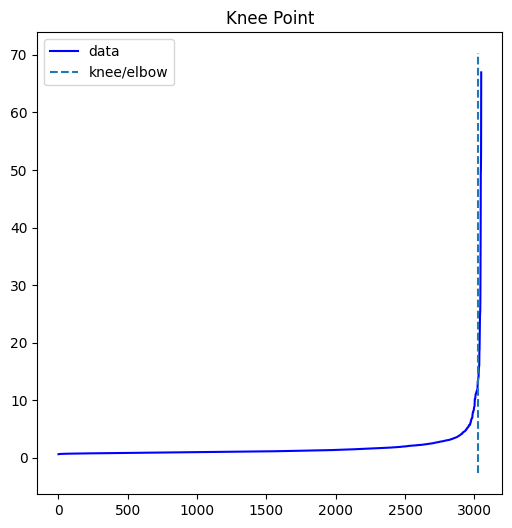

In [15]:
'''
DOC
https://www.reneshbedre.com/blog/dbscan-python.html
'''

# df_to_dbscan = scaled_df[cols].copy()
df_to_dbscan = scaled_df.copy()

# Número de vecinos
# NEIGHBORS = df_to_dbscan.shape[1]*2
NEIGHBORS = df_to_dbscan.shape[1] # Tantos como columnas -> dimension de los vectores

# kneighbors function returns distance of point to itself (i.e. first column will be zeros)
nbrs = NearestNeighbors(n_neighbors = NEIGHBORS).fit(scaled_df)

# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(scaled_df)

# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist = np.sort(neigh_dist, axis = 0)

k_dist = sort_neigh_dist[:, (NEIGHBORS - 1)]
# plt.plot(k_dist)
# plt.ylabel("k-NN distance")
# plt.xlabel("Sorted observations")
# plt.show()

kneedle = KneeLocator(x = range(1, len(neigh_dist)+1), y = k_dist, S = 1.0,
                      curve = "concave", direction = "increasing", online=True)

# get the estimate of knee point
print(kneedle.knee_y)
kneedle.plot_knee()
plt.show()

euclidean
###################################################################################
Estimated number of clusters: 22
Estimated number of noise points: 729
Silhouette Coefficient: 0.127
Davies-Bouldin Index: 0.844
Calinski-Harabasz Index: 82.059


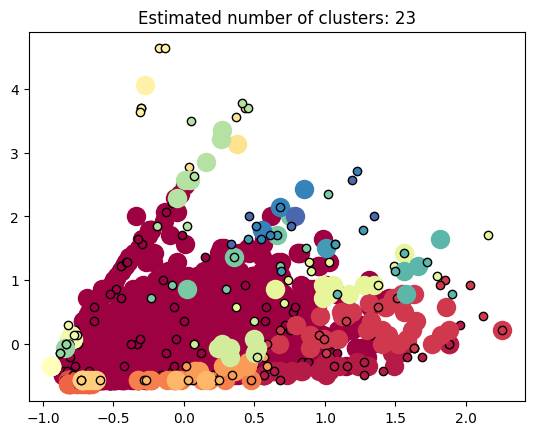

In [32]:
# # Calculo de eps y min_samples
# EPS = kneedle.knee_y
# MIN_SAMPLES = NEIGHBORS*2

# Mejores valores para menos ruido (a ojo)
EPS = 1
MIN_SAMPLES = 5

# Configuración del DBSCAN
config = {
    'eps': EPS,  # Radio de agrupación de vecinos
    'min_samples': MIN_SAMPLES,  # Mínimo número de puntos por cluster
    'metric': 'euclidean'  # Métrica de distancia
}

print(f"{config['metric']}")
print('###################################################################################')

# Llamada 1: Aplicar DBSCAN
db_data, db_labels, dbscan_model = dbscan_clustering(df_to_dbscan, config)

# Llamada 2: Calcular métricas del clustering no supervisado
metricas = dbscan_metrics(df_to_dbscan, db_labels)

# Llamada 3: Graficar resultados del clustering
dbscan_plot_results(df_to_dbscan.values, db_labels, dbscan_model)

___
___  

**EXPLICACION METRICAS**

1\. **Silhouette Coefficient (Coeficiente de Silueta)**: 0.325

   - El coeficiente de silueta varía entre -1 y 1, donde:

     - Un valor cercano a **1** indica que los puntos están bien agrupados dentro de su cluster y bien separados de otros clusters.

     - Un valor cercano a **0** indica que los puntos están en el borde de dos clusters, es decir, no están claramente diferenciados.

     - Un valor cercano a **-1** sugiere que los puntos han sido agrupados incorrectamente.

2\. **Davies-Bouldin Index**: 1.295

   - El **Índice de Davies-Bouldin** mide la compacidad de los clusters y la separación entre ellos.

     - Un valor **menor** es mejor, ya que indica que los clusters son compactos y bien separados entre sí.

     - El índice no tiene un rango superior fijo, pero valores cercanos a **0** son los ideales.

3\. **Calinski-Harabasz Index**: 308.713

   - El **Índice de Calinski-Harabasz**, también conocido como la **razón varianza entre clusters/varianza dentro del cluster**, mide cuán densos y separados están los clusters.

     - Un valor **más alto** es mejor, indicando clusters compactos (baja varianza dentro de ellos) y bien separados (alta varianza entre ellos).

     - No hay un límite superior fijo, pero un valor alto es deseado.

___
___

## Analisis

In [ ]:
km_m.view_pca_variance(feature_matrix_with_clusters)


In [ ]:
# # PCA 2 D
# pca_df = km_m.pca_visualization_2d(feature_matrix_with_clusters)

# display(pca_df.head())

In [ ]:
# explained_variance = km_m.pca_variance_plot(feature_matrix_with_clusters, 1)

# display(explained_variance)

In [ ]:
# Importancia de caracteristicas
# Preprocesamos datos
cluster_col='Cluster'
cols_to_scale = feature_matrix_with_clusters.columns.tolist()
df_clusters = feature_matrix_with_clusters[[cluster_col]].copy().reset_index(drop=True)
cols_to_scale.remove(cluster_col) # Columna Objetivo
preprocessed_df = pm.preprocess_features(feature_matrix_with_clusters[cols_to_scale])

# Combinar los DataFrames basándose en la columna 'Index'
preprocessed_df = pd.concat([preprocessed_df, df_clusters], axis=1)

clusters = kmeans_model.labels_

IMPORTANCE_THRES=0.05
prices_importance_df = km_m.get_feature_importances(preprocessed_df, clusters, imp_threshold=IMPORTANCE_THRES)

display(prices_importance_df.head(10))

## Dim redux

In [ ]:
# Dimension redux
pca_df, importance_df = km_m.redux_dimensions_pca_and_cluster(preprocessed_df, n_clusters=optimal_k, n_components=1)

## Descripcion

In [ ]:
# Descripcion de los clusters
# Ejecutar PCA y clustering
n_components = 1

df_with_pca, importance_df = km_m.pca_and_cluster(scaled_df, n_clusters=optimal_k, n_components=n_components)

# Mostrar el DataFrame con PCA y clustering
display(df_with_pca.head(5))

# Graficar la cantidad de items por cluster
# km_m.plot_items_per_cluster(df_with_pca)
show_clusters = km_m.plot_cluster_sizes(df_with_pca)

In [ ]:
# Seleccionamos las features según su importancia en el componente principal
importance_df_filt = importance_df[importance_df['Loading_PC1'] >= 0.05]

importance_df_filt

# Crear y mostrar descripciones de los clusters
description_df = km_m.create_cluster_descriptions(df_with_pca, importance_df_filt)
print('###########################################################')
print('Descripcion de los clusters')
print('###########################################################')
display(description_df)

In [ ]:
# Añadimos clusters a df_items
df_items = df_items.reset_index(drop=True) # Recuperamos indices originales

df_items_with_clusters = df_items.merge(df_with_pca[['Cluster']], left_index=True, right_index=True)

df_items_with_clusters.head()

In [ ]:
# Crear dataframe con las descripciones de los clusters
cluster_summary = {
    0: {
        'cluster_name': 'Moderate Performers',
        'description': 'Productos con ingresos medios y estables, con un rendimiento aceptable, pero sin alcanzar los niveles más altos. Presentan un crecimiento moderado, con baja variabilidad en sus ingresos.'
    },
    1: {
        'cluster_name': 'High Performers',
        'description': 'Productos con ingresos elevados en todas las métricas (SUM, MEAN, y MAX), lo que indica un buen desempeño continuo. Son productos que consistentemente generan buenas ventas con poca variabilidad.'
    },
    2: {
        'cluster_name': 'Top Performers with High Variability',
        'description': 'Productos con los ingresos más altos, pero con una notable variabilidad. Estos productos tienden a generar altos ingresos, pero sus ventas pueden ser impulsadas por promociones o eventos especiales.'
    },
    3: {
        'cluster_name': 'Underperformers',
        'description': 'Productos con ingresos bajos o incluso negativos en algunas métricas. Estos productos están rezagados en términos de rendimiento y podrían estar enfrentando dificultades para generar ingresos de manera constante.'
    }
}

cluster_summary_df = pd.DataFrame.from_dict(cluster_summary, orient='index')

# Asumiendo que tienes un dataframe `items_df` que tiene una columna 'cluster' con los números de cluster
# Realiza un merge con el resumen de clusters para añadir los nombres y descripciones al dataframe original
items_with_cluster_info = df_items_with_clusters.merge(cluster_summary_df, left_on='Cluster', right_index=True, how='left')

# Resultado: `items_with_cluster_info` tendrá las columnas adicionales 'cluster_name' y 'description'
display(items_with_cluster_info.head())

In [ ]:
km_m.plot_clusters_with_name(items_with_cluster_info)

## Guardamos csv

In [ ]:
# Guardamos df como csv
from google.colab import files

file_name = 'items_clusters_raw_earn.csv'

# # Exportar DataFrame a CSV (reemplaza 'df' por el nombre de tu DataFrame)
# items_with_cluster_info.to_csv(file_name, index=False)

# # Descargar el archivo CSV
# files.download(file_name)

# **PRODUCTOS: RANGO DE PRECIOS**
___
___

## Selección caracteristicas

In [ ]:
# V3
substrings = ['sell_price'] # Nos quedamos solo con las que afectan al precio de venta

feat_selected = fcm.select_features(features_descriptions, substrings)

print(f'Length Feats Selected: {len(feat_selected)}')
# display(feat_selected)

feature_matrix_selected = feature_matrix[feat_selected].copy()

# display(feature_matrix_selected.head(5))

# Aplicar filtros a las caracteristicas creadas
# Remove low information, highly correlated, highly null and single value features
filtered_feature_matrix = fcm.filter_feature_matrix(feature_matrix_selected)

# Renombrar características si es necesario # Evitamos este paso de momento
# feature_matrix_renamed = fcm.rename_features(filtered_feature_matrix, price_range_features)
feature_matrix_renamed = filtered_feature_matrix.copy()

display(feature_matrix_renamed.head(5))

## Preprocesamiento

In [ ]:
scaled_df = pm.preprocess_features(feature_matrix_renamed)

In [ ]:
scaled_df.head(5)

## Kmeans

### Elbow & Silhoutte

In [ ]:
km_m.plot_elbow_silhouette(scaled_df, 30)

In [ ]:
optimal_k = 4

kmeans_model, feature_matrix_with_clusters = km_m.apply_kmeans_and_plot(optimal_k, scaled_df, feature_matrix_renamed)

feature_matrix_with_clusters.head(5)

### Analisis

#### PCAs

In [ ]:
km_m.view_pca_variance(feature_matrix_with_clusters)

In [ ]:
# pca_df = km_m.pca_visualization_2d(feature_matrix_with_clusters)

# display(pca_df.head())

In [ ]:
# explained_variance = km_m.pca_variance_plot(feature_matrix_with_clusters, 1)

# display(explained_variance)

#### Importancia caracteristicas

In [ ]:
# Preprocesamos datos
cluster_col='Cluster'
cols_to_scale = feature_matrix_with_clusters.columns.tolist()
df_clusters = feature_matrix_with_clusters[[cluster_col]].copy().reset_index(drop=True)
cols_to_scale.remove(cluster_col) # Columna Objetivo
preprocessed_df = pm.preprocess_features(feature_matrix_with_clusters[cols_to_scale])

# Combinar los DataFrames basándose en la columna 'Index'
preprocessed_df = pd.concat([preprocessed_df, df_clusters], axis=1)

clusters = kmeans_model.labels_

IMPORTANCE_THRES=0.05
prices_importance_df = km_m.get_feature_importances(preprocessed_df, clusters, imp_threshold=IMPORTANCE_THRES)

display(prices_importance_df.head(10))

### Dimension Redux

In [ ]:
pca_df, importance_df = km_m.redux_dimensions_pca_and_cluster(preprocessed_df, n_clusters=optimal_k, n_components=1)

In [ ]:
# El segundo componente es residual
# pca_df, importance_df = km_m.redux_dimensions_pca_and_cluster(preprocessed_df, n_clusters=optimal_k, n_components=2)

## Descripcion de los clusters

In [ ]:
# Ejecutar PCA y clustering
optimal_k = 4
n_components = 1

df_with_pca, importance_df = km_m.pca_and_cluster(scaled_df, n_clusters=optimal_k, n_components=n_components)

# Mostrar el DataFrame con PCA y clustering
display(df_with_pca.head(5))

# Graficar la cantidad de items por cluster
# km_m.plot_items_per_cluster(df_with_pca)
show_clusters = km_m.plot_cluster_sizes(df_with_pca)

### Mostrar Descripcions

In [ ]:
# Seleccionamos las features según su importancia en el componente principal
importance_df_filt = importance_df[importance_df['Loading_PC1'] >= 0.05]

# Crear y mostrar descripciones de los clusters
description_df = km_m.create_cluster_descriptions(df_with_pca, importance_df_filt)
print('###########################################################')
print('Descripcion de los clusters')
print('###########################################################')
display(description_df)

### Asignacion clusters a items

In [ ]:
# Añadimos clusters a df_items
df_items = df_items.reset_index(drop=True) # Recuperamos indices originales

df_items_with_clusters = df_items.merge(df_with_pca[['Cluster']], left_index=True, right_index=True)

df_items_with_clusters.head()

In [ ]:
# Crear dataframe con las descripciones de los clusters
cluster_summary = {
    0: {
        'cluster_name': 'Very High Price',
        'description': 'Productos con precios extremadamente altos en todas las métricas, con una gran variabilidad y dispersion de precios.'
    },
    1: {
        'cluster_name': 'Moderate Price with Low Variability',
        'description': 'Productos de precio moderado, con variación de precios limitada. Los productos parecen estar en un rango estable de precios medios.'
    },
    2: {
        'cluster_name': 'High Price with Stability',
        'description': 'Productos de precio alto con cierta estabilidad en los precios, pero manteniendo variación considerable en el precio máximo y promedio.'
    },
    3: {
        'cluster_name': 'Slightly Above Average Price',
        'description': 'Productos con precios ligeramente superiores al promedio, pero con una variación significativa en los precios máximos y mínimos.'
    }
}

cluster_summary_df = pd.DataFrame.from_dict(cluster_summary, orient='index')

# Asumiendo que tienes un dataframe `items_df` que tiene una columna 'cluster' con los números de cluster
# Realiza un merge con el resumen de clusters para añadir los nombres y descripciones al dataframe original
items_with_cluster_info = df_items_with_clusters.merge(cluster_summary_df, left_on='Cluster', right_index=True, how='left')

items_with_cluster_info = items_with_cluster_info.rename(columns={'Cluster':'cluster'})

# Resultado: `items_with_cluster_info` tendrá las columnas adicionales 'cluster_name' y 'description'
display(items_with_cluster_info.head())

### Plot clusters con descripcion

In [ ]:
km_m.plot_clusters_with_name(items_with_cluster_info)

## Guardamos CSV

In [ ]:
# Guardamos df como csv
from google.colab import files

file_name = 'items_clusters_price_range.csv'

# # Exportar DataFrame a CSV (reemplaza 'df' por el nombre de tu DataFrame)
# items_with_cluster_info.to_csv(file_name, index=False)

# # Descargar el archivo CSV
# files.download(file_name)

# **PRODUCTOS: EVENTOS**  
  
**Efecto de eventos en ventas de productos**
___
___

## Creacion caracteristicas

In [ ]:
# Añadir año y semana a calendar para poder añadir eventos a weekly sales
df_cal['fecha'] = pd.to_datetime(df_cal['fecha'])

df_cal['year'] = df_cal['fecha'].dt.year
df_cal['week'] = df_cal['fecha'].dt.isocalendar().week

# Añadir la columna event de df_cal a df_ws usando las columnas year y week (añadir estas dos tambien a df_ws)
df_ws = df_ws.merge(df_cal[['year', 'week', 'event']], on=['year', 'week'], how='left')

# Rellenar NaN columna event de df_ws con 'None' (str)
df_ws['event'] = df_ws['event'].fillna('None')

In [ ]:
display(df_items.head())
display(df_shops.head())
display(df_ws.head())

In [ ]:
# OHE para columna event en df_ws usando sklearn.preprocessing
from sklearn.preprocessing import OneHotEncoder

# Seleccionar la columna 'event' para codificar
events = df_ws[['event']]

# Crear el OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Ajustar y transformar los eventos con OHE
event_encoded = ohe.fit_transform(events)

# Crear un DataFrame con las columnas codificadas
event_encoded_df = pd.DataFrame(event_encoded, columns=ohe.get_feature_names_out(['event']))

# Concatenar con el DataFrame original de ventas
df_ws_ohe = pd.concat([df_ws.reset_index(drop=True), event_encoded_df], axis=1)

# Ver el resultado
df_ws_ohe.head()


In [ ]:
import featuretools as ft

# Crear un EntitySet
es = ft.EntitySet(id='sales_data')

# Agregar entidades
es = es.add_dataframe(dataframe_name="items", dataframe=df_items, index="item")
es = es.add_dataframe(dataframe_name="shops", dataframe=df_shops, index="store_code")
es = es.add_dataframe(dataframe_name="sales", dataframe=df_ws_ohe, index="id",
                      time_index="week",
                      secondary_time_index={'year': ['units', 'sell_price', 'raw_earn']})

# Definir relaciones
es = es.add_relationship("items", "item", "sales", "item")
es = es.add_relationship("shops", "store_code", "sales", "store_code")

# Generar características automáticas, ahora centradas en "items"
feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_dataframe_name="items",  # Objetivo: productos
                                      agg_primitives=[
                                          "sum", "mean", "count"  # Agregación sobre ventas
                                      ],
                                      trans_primitives=["year"],  # Primitivas de transformación, usando 'year'
                                      max_depth=2)

feature_matrix.head()

## Selección caracteristicas

In [ ]:
# Revision definiciones caracteristicas creadas
features_descriptions = fcm.get_features_descriptions(feature_defs)

display(type(features_descriptions))

display(features_descriptions)

In [ ]:
# V3
substrings = ['event', 'raw_earn'] # Nos quedamos solo con las que afectan a ventas

print(f'Length All features: {len(features_descriptions)}')

feat_selected = fcm.select_features(features_descriptions, substrings)

print(f'Length Feats Selected: {len(feat_selected)}')
# display(feat_selected)

feature_matrix_selected = feature_matrix[feat_selected].copy()

# display(feature_matrix_selected.head(5))

# Aplicar filtros a las caracteristicas creadas
# Remove low information, highly correlated, highly null and single value features
filtered_feature_matrix = fcm.filter_feature_matrix(feature_matrix_selected)

# Renombrar características si es necesario # Evitamos este paso de momento
# feature_matrix_renamed = fcm.rename_features(filtered_feature_matrix, price_range_features)
feature_matrix_renamed = filtered_feature_matrix.copy()

display(feature_matrix_renamed.head(5))

## Preprocesamiento

In [ ]:
scaled_df = pm.preprocess_features(feature_matrix_renamed)

scaled_df.head()

## Kmeans

### Elbow & Silhoutte

In [ ]:
km_m.plot_elbow_silhouette(scaled_df, 30)

In [ ]:
# Apreciamos varias opciones 4 o 5
optimal_k = 5

kmeans_model, feature_matrix_with_clusters = km_m.apply_kmeans_and_plot(optimal_k, scaled_df, feature_matrix_renamed)

feature_matrix_with_clusters.head(5)

### Analisis

#### PCAs

In [ ]:
km_m.view_pca_variance(feature_matrix_with_clusters)

In [ ]:
# pca_df = km_m.pca_visualization_2d(feature_matrix_with_clusters)

# display(pca_df.head())

In [ ]:
# explained_variance = km_m.pca_variance_plot(feature_matrix_with_clusters, 1)

# display(explained_variance)

#### Importancia caracteristicas

In [ ]:
# Preprocesamos datos
cluster_col='Cluster'
cols_to_scale = feature_matrix_with_clusters.columns.tolist()
df_clusters = feature_matrix_with_clusters[[cluster_col]].copy().reset_index(drop=True)
cols_to_scale.remove(cluster_col) # Columna Objetivo
preprocessed_df = pm.preprocess_features(feature_matrix_with_clusters[cols_to_scale])

# Combinar los DataFrames basándose en la columna 'Index'
preprocessed_df = pd.concat([preprocessed_df, df_clusters], axis=1)

clusters = kmeans_model.labels_

IMPORTANCE_THRES=0.05
prices_importance_df = km_m.get_feature_importances(preprocessed_df, clusters, imp_threshold=IMPORTANCE_THRES)

display(prices_importance_df.head(10))

### Dimension Redux

In [ ]:
pca_df, importance_df = km_m.redux_dimensions_pca_and_cluster(preprocessed_df, n_clusters=optimal_k, n_components=1)

In [ ]:
# El segundo componente es residual
# pca_df, importance_df = km_m.redux_dimensions_pca_and_cluster(preprocessed_df, n_clusters=optimal_k, n_components=2)

## Descripcion de los clusters

In [ ]:
# Ejecutar PCA y clustering
optimal_k = 5
n_components = 1

df_with_pca, importance_df = km_m.pca_and_cluster(scaled_df, n_clusters=optimal_k, n_components=n_components)

# Mostrar el DataFrame con PCA y clustering
display(df_with_pca.head(5))

# Graficar la cantidad de items por cluster
# km_m.plot_items_per_cluster(df_with_pca)
show_clusters = km_m.plot_cluster_sizes(df_with_pca)

### Mostrar Descripcions

In [ ]:
# Seleccionamos las features según su importancia en el componente principal
importance_df_filt = importance_df[importance_df['Loading_PC1'] >= 0.05]

importance_df_filt

# Crear y mostrar descripciones de los clusters
description_df = km_m.create_cluster_descriptions(df_with_pca, importance_df_filt)
print('###########################################################')
print('Descripcion de los clusters')
print('###########################################################')
display(description_df)

In [ ]:
description_df[sorted(description_df.columns)]


### Asignacion clusters a items

In [ ]:
# Añadimos clusters a df_items
df_items = df_items.reset_index(drop=True) # Recuperamos indices originales

df_items_with_clusters = df_items.merge(df_with_pca[['Cluster']], left_index=True, right_index=True)

df_items_with_clusters.head()

In [ ]:
# Crear dataframe con las descripciones de los clusters
cluster_summary = {
    0: {
        'cluster_name': 'Negative Impact Products',
        'description': 'Productos que presentan un impacto negativo en ingresos durante la mayoría de los eventos, con una ligera caída en las ventas durante festividades como el Año Nuevo y la Pascua.'
    },
    1: {
        'cluster_name': 'High Seasonal Performance',
        'description': 'Productos con ingresos muy elevados, especialmente durante eventos importantes como el Año Nuevo y el Super Bowl. Su desempeño está fuertemente ligado a eventos específicos.'
    },
    2: {
        'cluster_name': 'Event-Driven Premium Products',
        'description': 'Productos con ingresos muy altos y sensibilidad a eventos como el Año Nuevo y el Super Bowl. Estos productos tienden a rendir mejor en fechas especiales.'
    },
    3: {
        'cluster_name': 'Moderate Event Sensitivity',
        'description': 'Productos que muestran un desempeño positivo moderado durante eventos, sin grandes variaciones. Están ligeramente influenciados por eventos como el Año Nuevo, Pascua y el Super Bowl.'
    },
    4: {
        'cluster_name': 'Event-Resistant Products',
        'description': 'Productos con un impacto marginalmente positivo durante eventos, pero que no dependen fuertemente de los mismos. Muestran estabilidad en ventas, independientemente de festividades.'
    }
}

cluster_summary_df = pd.DataFrame.from_dict(cluster_summary, orient='index')

# Asumiendo que tienes un dataframe `items_df` que tiene una columna 'cluster' con los números de cluster
# Realiza un merge con el resumen de clusters para añadir los nombres y descripciones al dataframe original
items_with_cluster_info = df_items_with_clusters.merge(cluster_summary_df, left_on='Cluster', right_index=True, how='left')

items_with_cluster_info = items_with_cluster_info.rename(columns={'Cluster':'cluster'})

# Resultado: `items_with_cluster_info` tendrá las columnas adicionales 'cluster_name' y 'description'
display(items_with_cluster_info.head())

### Plot clusters con descripcion

In [ ]:
km_m.plot_clusters_with_name(items_with_cluster_info)

## Guardamos CSV

In [ ]:
# Guardamos df como csv
from google.colab import files

file_name = 'items_clusters_events_influence_sales.csv'

# # Exportar DataFrame a CSV (reemplaza 'df' por el nombre de tu DataFrame)
# items_with_cluster_info.to_csv(file_name, index=False)

# # Descargar el archivo CSV
# files.download(file_name)

___
___